In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torchvision.models as models
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

/home/bami/anaconda3/envs/MIS/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bami/anaconda3/envs/MIS/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dir = '/data/nas2/KJA/MIS/LIDC dataset/'

A = [dir+'/Consistency/BB/A/'+items for items in os.listdir(dir+'/Consistency/BB/A/')]
B = [dir+'/Consistency/BB/B/'+items for items in os.listdir(dir+'/Consistency/BB/B/')]
A.sort()
B.sort()
B = B[1:601]
A = A[1:]

In [3]:
A_img = [dir+'/A/'+items for items in os.listdir(dir+'A')]
C_img = [dir+'/C/'+items for items in os.listdir(dir+'C')]
A_img.sort()
C_img.sort()
A_img = A_img[:125]
C_img = C_img[:125]

In [4]:
C_labels = np.zeros((125)).astype(int)
A_labels = np.ones((125)).astype(int)

In [5]:
img_pairs = []
img_pair_labels = []

for i in range(125):
    currentA = A_img[i]
    pos_img = A_img[124-i]
    img_pairs.append([currentA, pos_img])
    img_pair_labels.append(1)
for i in range(125):
    currentA = A_img[i]
    pos_C = C_img[124-i]
    img_pairs.append([currentA, pos_C])
    img_pair_labels.append(0)

In [6]:
class AnnotationStyleDataset(Dataset):
    def __init__(self, image_pairs, labels, transform=None):
        # self.mask_pairs = mask_pairs
        self.image_pairs = image_pairs
        self.labels = labels
        self.transform = transform


    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        # mask1_path, mask2_path = self.mask_pairs[idx]
        img1_path, img2_path = self.image_pairs[idx]
        
        # mask1 = Image.open(mask1_path).convert('L')
        # mask2 = Image.open(mask2_path).convert('L')

        img1 = Image.open(img1_path).convert('L')
        img2 = Image.open(img2_path).convert('L')
        
        label = self.labels[idx]

        # mask1_np = np.array(mask1)  # Shape: [H, W]
        # mask2_np = np.array(mask2)
        img1_np = np.array(img1)
        img2_np = np.array(img2)

        fin1_np = np.stack([img1_np, img1_np, img1_np], axis=-1)  # Shape: [H, W, 3]
        fin2_np = np.stack([img2_np, img2_np, img2_np], axis=-1)  # Shape: [H, W, 3]

        # Convert back to PIL Image (so that transforms can be applied)
        fin1 = Image.fromarray(fin1_np)
        fin2 = Image.fromarray(fin2_np)

        if self.transform:
            fin1 = self.transform(fin1)
            fin2 = self.transform(fin2)

        return fin1, fin2, torch.tensor(label, dtype=torch.float32)

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import cv2

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = models.densenet161(pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove classification head

        self.fc1 = nn.Linear(2210, 1024)  # 2208 features + 2 Hu moments
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)

    def extract_hu_moments(self, img):
        binary = img[:][0] > 1
        binary = binary.astype(np.uint8)
        moments = cv2.moments(binary)
        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        hu_selected = np.array([hu_moments[2], hu_moments[6]])
        return hu_selected

    def forward_once(self, x):
        batch_size = x.shape[0]
        x_np = x.permute(0, 2, 3, 1).cpu().numpy()
        hu_moments_batch = [self.extract_hu_moments(img) for img in x_np]
        hu_moments_tensor = torch.tensor(hu_moments_batch, dtype=torch.float32, device=x.device)

        x = self.cnn.features(x)  # (B, 2208, 7, 7)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)  # (B, 2208)
        x = torch.cat((x, hu_moments_tensor), dim=1)  # (B, 2210)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.fc6(x)
        x = self.dropout(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2)
        loss = torch.mean(
            label * torch.pow(distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        )
        return loss


In [9]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = AnnotationStyleDataset(img_pairs, img_pair_labels, transform=transform)

train_idx, val_idx = train_test_split(
    range(len(dataset)),  # Generates an index list from 0 to len(dataset)-1
    test_size=0.3,  # 30% of the data goes into the validation set
    stratify=img_pair_labels,  # Stratify the split based on the labels
    random_state=99  # For reproducibility
)

# Create subsets for training and validation
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=16)

In [11]:
model = SiameseNetwork()
device = torch.device("cuda:1")
model = model.to(device)

criterion = ContrastiveLoss(margin=1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
best_val_loss = float('inf')
patience = 50  # Number of epochs to wait before stopping
counter = 0

num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    num_train_samples = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for img1, img2, label in tepoch:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * img1.size(0)
            num_train_samples += img1.size(0)
            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / num_train_samples

    model.eval()
    total_val_loss = 0.0
    num_val_samples = 0

    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            total_val_loss += loss.item() * img1.size(0)
            num_val_samples += img1.size(0)

    avg_val_loss = total_val_loss / num_val_samples
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'Siamese_AAAC_LIDC1.pth')
        print("✅ Best model saved!")
    else:
        counter += 1
        print(f"⏳ Early stopping counter: {counter}/{patience}")

    if counter >= patience:
        print("⛔ Early stopping triggered! Training stopped.")
        break

Epoch 1/1000:   0%|                                         | 0/11 [00:00<?, ?batch/s]/tmp/ipykernel_31410/1389646898.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/torch/csrc/utils/tensor_new.cpp:274.)
  hu_moments_tensor = torch.tensor(hu_moments_batch, dtype=torch.float32, device=x.device)
Epoch 1/1000: 100%|█████████████████████| 11/11 [00:07<00:00,  1.43batch/s, loss=8.67]


Epoch [1/1000] - Train Loss: 12.1414 | Val Loss: 0.3029
✅ Best model saved!


Epoch 2/1000: 100%|█████████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=3.16]


Epoch [2/1000] - Train Loss: 4.8419 | Val Loss: 2.0986
⏳ Early stopping counter: 1/50


Epoch 3/1000: 100%|██████████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=1.7]


Epoch [3/1000] - Train Loss: 2.7717 | Val Loss: 1.8351
⏳ Early stopping counter: 2/50


Epoch 4/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.68batch/s, loss=0.911]


Epoch [4/1000] - Train Loss: 1.4671 | Val Loss: 1.1893
⏳ Early stopping counter: 3/50


Epoch 5/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.70batch/s, loss=0.982]


Epoch [5/1000] - Train Loss: 0.8331 | Val Loss: 0.5772
⏳ Early stopping counter: 4/50


Epoch 6/1000: 100%|█████████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.44]


Epoch [6/1000] - Train Loss: 0.6053 | Val Loss: 0.4476
⏳ Early stopping counter: 5/50


Epoch 7/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.252]


Epoch [7/1000] - Train Loss: 0.4404 | Val Loss: 0.3927
⏳ Early stopping counter: 6/50


Epoch 8/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.204]


Epoch [8/1000] - Train Loss: 0.3599 | Val Loss: 0.5430
⏳ Early stopping counter: 7/50


Epoch 9/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.68batch/s, loss=0.333]


Epoch [9/1000] - Train Loss: 0.3188 | Val Loss: 0.3070
⏳ Early stopping counter: 8/50


Epoch 10/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.205]


Epoch [10/1000] - Train Loss: 0.2896 | Val Loss: 0.3030
⏳ Early stopping counter: 9/50


Epoch 11/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.341]


Epoch [11/1000] - Train Loss: 0.2880 | Val Loss: 0.3421
⏳ Early stopping counter: 10/50


Epoch 12/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.307]


Epoch [12/1000] - Train Loss: 0.2808 | Val Loss: 0.3460
⏳ Early stopping counter: 11/50


Epoch 13/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.276]


Epoch [13/1000] - Train Loss: 0.2644 | Val Loss: 0.3871
⏳ Early stopping counter: 12/50


Epoch 14/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.68batch/s, loss=0.218]


Epoch [14/1000] - Train Loss: 0.2650 | Val Loss: 0.3009
✅ Best model saved!


Epoch 15/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.337]


Epoch [15/1000] - Train Loss: 0.2728 | Val Loss: 0.3314
⏳ Early stopping counter: 1/50


Epoch 16/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.281]


Epoch [16/1000] - Train Loss: 0.2426 | Val Loss: 0.3231
⏳ Early stopping counter: 2/50


Epoch 17/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.275]


Epoch [17/1000] - Train Loss: 0.2841 | Val Loss: 0.2990
✅ Best model saved!


Epoch 18/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.305]


Epoch [18/1000] - Train Loss: 0.2618 | Val Loss: 0.3311
⏳ Early stopping counter: 1/50


Epoch 19/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.231]


Epoch [19/1000] - Train Loss: 0.2636 | Val Loss: 0.3246
⏳ Early stopping counter: 2/50


Epoch 20/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.69batch/s, loss=0.322]


Epoch [20/1000] - Train Loss: 0.2579 | Val Loss: 0.3127
⏳ Early stopping counter: 3/50


Epoch 21/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.311]


Epoch [21/1000] - Train Loss: 0.2481 | Val Loss: 0.2953
✅ Best model saved!


Epoch 22/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.208]


Epoch [22/1000] - Train Loss: 0.2450 | Val Loss: 0.3089
⏳ Early stopping counter: 1/50


Epoch 23/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.215]


Epoch [23/1000] - Train Loss: 0.2480 | Val Loss: 0.3316
⏳ Early stopping counter: 2/50


Epoch 24/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.344]


Epoch [24/1000] - Train Loss: 0.2508 | Val Loss: 0.3089
⏳ Early stopping counter: 3/50


Epoch 25/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.239]


Epoch [25/1000] - Train Loss: 0.2467 | Val Loss: 0.3357
⏳ Early stopping counter: 4/50


Epoch 26/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.276]


Epoch [26/1000] - Train Loss: 0.2493 | Val Loss: 0.2872
✅ Best model saved!


Epoch 27/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.217]


Epoch [27/1000] - Train Loss: 0.2380 | Val Loss: 0.3141
⏳ Early stopping counter: 1/50


Epoch 28/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.243]


Epoch [28/1000] - Train Loss: 0.2475 | Val Loss: 0.3114
⏳ Early stopping counter: 2/50


Epoch 29/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.217]


Epoch [29/1000] - Train Loss: 0.2406 | Val Loss: 0.2972
⏳ Early stopping counter: 3/50


Epoch 30/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.252]


Epoch [30/1000] - Train Loss: 0.2528 | Val Loss: 0.3027
⏳ Early stopping counter: 4/50


Epoch 31/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.338]


Epoch [31/1000] - Train Loss: 0.2419 | Val Loss: 0.3052
⏳ Early stopping counter: 5/50


Epoch 32/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.293]


Epoch [32/1000] - Train Loss: 0.2593 | Val Loss: 0.3007
⏳ Early stopping counter: 6/50


Epoch 33/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.208]


Epoch [33/1000] - Train Loss: 0.2304 | Val Loss: 0.3692
⏳ Early stopping counter: 7/50


Epoch 34/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.266]


Epoch [34/1000] - Train Loss: 0.2406 | Val Loss: 0.2978
⏳ Early stopping counter: 8/50


Epoch 35/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.307]


Epoch [35/1000] - Train Loss: 0.2537 | Val Loss: 0.2902
⏳ Early stopping counter: 9/50


Epoch 36/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.239]


Epoch [36/1000] - Train Loss: 0.2496 | Val Loss: 0.2958
⏳ Early stopping counter: 10/50


Epoch 37/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.28]


Epoch [37/1000] - Train Loss: 0.2308 | Val Loss: 0.3127
⏳ Early stopping counter: 11/50


Epoch 38/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.232]


Epoch [38/1000] - Train Loss: 0.2415 | Val Loss: 0.3124
⏳ Early stopping counter: 12/50


Epoch 39/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.219]


Epoch [39/1000] - Train Loss: 0.2353 | Val Loss: 0.3032
⏳ Early stopping counter: 13/50


Epoch 40/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.255]


Epoch [40/1000] - Train Loss: 0.2387 | Val Loss: 0.3123
⏳ Early stopping counter: 14/50


Epoch 41/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.213]


Epoch [41/1000] - Train Loss: 0.2248 | Val Loss: 0.2806
✅ Best model saved!


Epoch 42/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.214]


Epoch [42/1000] - Train Loss: 0.2224 | Val Loss: 0.3356
⏳ Early stopping counter: 1/50


Epoch 43/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.298]


Epoch [43/1000] - Train Loss: 0.2241 | Val Loss: 0.2871
⏳ Early stopping counter: 2/50


Epoch 44/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.325]


Epoch [44/1000] - Train Loss: 0.2352 | Val Loss: 0.3186
⏳ Early stopping counter: 3/50


Epoch 45/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.231]


Epoch [45/1000] - Train Loss: 0.2350 | Val Loss: 0.2737
✅ Best model saved!


Epoch 46/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.225]


Epoch [46/1000] - Train Loss: 0.2361 | Val Loss: 0.3097
⏳ Early stopping counter: 1/50


Epoch 47/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.302]


Epoch [47/1000] - Train Loss: 0.2338 | Val Loss: 0.2831
⏳ Early stopping counter: 2/50


Epoch 48/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.328]


Epoch [48/1000] - Train Loss: 0.2225 | Val Loss: 0.3093
⏳ Early stopping counter: 3/50


Epoch 49/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.18]


Epoch [49/1000] - Train Loss: 0.2170 | Val Loss: 0.3262
⏳ Early stopping counter: 4/50


Epoch 50/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.228]


Epoch [50/1000] - Train Loss: 0.2270 | Val Loss: 0.2942
⏳ Early stopping counter: 5/50


Epoch 51/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.219]


Epoch [51/1000] - Train Loss: 0.2198 | Val Loss: 0.3675
⏳ Early stopping counter: 6/50


Epoch 52/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.263]


Epoch [52/1000] - Train Loss: 0.2212 | Val Loss: 0.2768
⏳ Early stopping counter: 7/50


Epoch 53/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.171]


Epoch [53/1000] - Train Loss: 0.2067 | Val Loss: 0.2790
⏳ Early stopping counter: 8/50


Epoch 54/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.204]


Epoch [54/1000] - Train Loss: 0.2103 | Val Loss: 0.3400
⏳ Early stopping counter: 9/50


Epoch 55/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.231]


Epoch [55/1000] - Train Loss: 0.2130 | Val Loss: 0.2684
✅ Best model saved!


Epoch 56/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.209]


Epoch [56/1000] - Train Loss: 0.2067 | Val Loss: 0.2688
⏳ Early stopping counter: 1/50


Epoch 57/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.163]


Epoch [57/1000] - Train Loss: 0.2016 | Val Loss: 0.2713
⏳ Early stopping counter: 2/50


Epoch 58/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.242]


Epoch [58/1000] - Train Loss: 0.2080 | Val Loss: 0.2389
✅ Best model saved!


Epoch 59/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.59batch/s, loss=0.166]


Epoch [59/1000] - Train Loss: 0.2038 | Val Loss: 0.2905
⏳ Early stopping counter: 1/50


Epoch 60/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.225]


Epoch [60/1000] - Train Loss: 0.2158 | Val Loss: 0.2527
⏳ Early stopping counter: 2/50


Epoch 61/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.202]


Epoch [61/1000] - Train Loss: 0.2052 | Val Loss: 0.2706
⏳ Early stopping counter: 3/50


Epoch 62/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.231]


Epoch [62/1000] - Train Loss: 0.2143 | Val Loss: 0.2374
✅ Best model saved!


Epoch 63/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.197]


Epoch [63/1000] - Train Loss: 0.2048 | Val Loss: 0.2550
⏳ Early stopping counter: 1/50


Epoch 64/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.23]


Epoch [64/1000] - Train Loss: 0.1968 | Val Loss: 0.2875
⏳ Early stopping counter: 2/50


Epoch 65/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.248]


Epoch [65/1000] - Train Loss: 0.2071 | Val Loss: 0.2503
⏳ Early stopping counter: 3/50


Epoch 66/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.27]


Epoch [66/1000] - Train Loss: 0.2275 | Val Loss: 0.2835
⏳ Early stopping counter: 4/50


Epoch 67/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.187]


Epoch [67/1000] - Train Loss: 0.2118 | Val Loss: 0.2483
⏳ Early stopping counter: 5/50


Epoch 68/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.219]


Epoch [68/1000] - Train Loss: 0.2057 | Val Loss: 0.2524
⏳ Early stopping counter: 6/50


Epoch 69/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.15]


Epoch [69/1000] - Train Loss: 0.1935 | Val Loss: 0.2581
⏳ Early stopping counter: 7/50


Epoch 70/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.196]


Epoch [70/1000] - Train Loss: 0.1873 | Val Loss: 0.2648
⏳ Early stopping counter: 8/50


Epoch 71/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.212]


Epoch [71/1000] - Train Loss: 0.1945 | Val Loss: 0.2440
⏳ Early stopping counter: 9/50


Epoch 72/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.206]


Epoch [72/1000] - Train Loss: 0.1811 | Val Loss: 0.2708
⏳ Early stopping counter: 10/50


Epoch 73/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.191]


Epoch [73/1000] - Train Loss: 0.1901 | Val Loss: 0.2627
⏳ Early stopping counter: 11/50


Epoch 74/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.212]


Epoch [74/1000] - Train Loss: 0.1904 | Val Loss: 0.2431
⏳ Early stopping counter: 12/50


Epoch 75/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.155]


Epoch [75/1000] - Train Loss: 0.2015 | Val Loss: 0.2572
⏳ Early stopping counter: 13/50


Epoch 76/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.227]


Epoch [76/1000] - Train Loss: 0.1914 | Val Loss: 0.2527
⏳ Early stopping counter: 14/50


Epoch 77/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.193]


Epoch [77/1000] - Train Loss: 0.1905 | Val Loss: 0.2545
⏳ Early stopping counter: 15/50


Epoch 78/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.25]


Epoch [78/1000] - Train Loss: 0.2008 | Val Loss: 0.2597
⏳ Early stopping counter: 16/50


Epoch 79/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.203]


Epoch [79/1000] - Train Loss: 0.1758 | Val Loss: 0.2259
✅ Best model saved!


Epoch 80/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.149]


Epoch [80/1000] - Train Loss: 0.1785 | Val Loss: 0.2640
⏳ Early stopping counter: 1/50


Epoch 81/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.218]


Epoch [81/1000] - Train Loss: 0.1852 | Val Loss: 0.2664
⏳ Early stopping counter: 2/50


Epoch 82/1000: 100%|████████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.22]


Epoch [82/1000] - Train Loss: 0.1786 | Val Loss: 0.2246
✅ Best model saved!


Epoch 83/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.161]


Epoch [83/1000] - Train Loss: 0.1710 | Val Loss: 0.2344
⏳ Early stopping counter: 1/50


Epoch 84/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.134]


Epoch [84/1000] - Train Loss: 0.1626 | Val Loss: 0.2507
⏳ Early stopping counter: 2/50


Epoch 85/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.135]


Epoch [85/1000] - Train Loss: 0.1801 | Val Loss: 0.2517
⏳ Early stopping counter: 3/50


Epoch 86/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.085]


Epoch [86/1000] - Train Loss: 0.1552 | Val Loss: 0.2126
✅ Best model saved!


Epoch 87/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.175]


Epoch [87/1000] - Train Loss: 0.1716 | Val Loss: 0.2536
⏳ Early stopping counter: 1/50


Epoch 88/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.114]


Epoch [88/1000] - Train Loss: 0.1622 | Val Loss: 0.2529
⏳ Early stopping counter: 2/50


Epoch 89/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.141]


Epoch [89/1000] - Train Loss: 0.1882 | Val Loss: 0.2520
⏳ Early stopping counter: 3/50


Epoch 90/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.188]


Epoch [90/1000] - Train Loss: 0.1840 | Val Loss: 0.2334
⏳ Early stopping counter: 4/50


Epoch 91/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.124]


Epoch [91/1000] - Train Loss: 0.1731 | Val Loss: 0.2343
⏳ Early stopping counter: 5/50


Epoch 92/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.144]


Epoch [92/1000] - Train Loss: 0.1843 | Val Loss: 0.2518
⏳ Early stopping counter: 6/50


Epoch 93/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.248]


Epoch [93/1000] - Train Loss: 0.1891 | Val Loss: 0.2454
⏳ Early stopping counter: 7/50


Epoch 94/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.158]


Epoch [94/1000] - Train Loss: 0.1707 | Val Loss: 0.2172
⏳ Early stopping counter: 8/50


Epoch 95/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.188]


Epoch [95/1000] - Train Loss: 0.1569 | Val Loss: 0.2217
⏳ Early stopping counter: 9/50


Epoch 96/1000: 100%|█████████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.2]


Epoch [96/1000] - Train Loss: 0.1576 | Val Loss: 0.2649
⏳ Early stopping counter: 10/50


Epoch 97/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.342]


Epoch [97/1000] - Train Loss: 0.1785 | Val Loss: 0.2825
⏳ Early stopping counter: 11/50


Epoch 98/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.155]


Epoch [98/1000] - Train Loss: 0.1674 | Val Loss: 0.2314
⏳ Early stopping counter: 12/50


Epoch 99/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.168]


Epoch [99/1000] - Train Loss: 0.1678 | Val Loss: 0.2144
⏳ Early stopping counter: 13/50


Epoch 100/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.175]


Epoch [100/1000] - Train Loss: 0.1632 | Val Loss: 0.2424
⏳ Early stopping counter: 14/50


Epoch 101/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.121]


Epoch [101/1000] - Train Loss: 0.1633 | Val Loss: 0.2571
⏳ Early stopping counter: 15/50


Epoch 102/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.17]


Epoch [102/1000] - Train Loss: 0.1571 | Val Loss: 0.2358
⏳ Early stopping counter: 16/50


Epoch 103/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.61batch/s, loss=0.202]


Epoch [103/1000] - Train Loss: 0.1540 | Val Loss: 0.2107
✅ Best model saved!


Epoch 104/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.125]


Epoch [104/1000] - Train Loss: 0.1467 | Val Loss: 0.2272
⏳ Early stopping counter: 1/50


Epoch 105/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.58batch/s, loss=0.167]


Epoch [105/1000] - Train Loss: 0.1525 | Val Loss: 0.2723
⏳ Early stopping counter: 2/50


Epoch 106/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.58batch/s, loss=0.143]


Epoch [106/1000] - Train Loss: 0.1419 | Val Loss: 0.2324
⏳ Early stopping counter: 3/50


Epoch 107/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.59batch/s, loss=0.18]


Epoch [107/1000] - Train Loss: 0.1629 | Val Loss: 0.2826
⏳ Early stopping counter: 4/50


Epoch 108/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.61batch/s, loss=0.178]


Epoch [108/1000] - Train Loss: 0.1457 | Val Loss: 0.2341
⏳ Early stopping counter: 5/50


Epoch 109/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.196]


Epoch [109/1000] - Train Loss: 0.1627 | Val Loss: 0.2536
⏳ Early stopping counter: 6/50


Epoch 110/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.277]


Epoch [110/1000] - Train Loss: 0.1753 | Val Loss: 0.2472
⏳ Early stopping counter: 7/50


Epoch 111/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.182]


Epoch [111/1000] - Train Loss: 0.1643 | Val Loss: 0.1637
✅ Best model saved!


Epoch 112/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.149]


Epoch [112/1000] - Train Loss: 0.1471 | Val Loss: 0.1896
⏳ Early stopping counter: 1/50


Epoch 113/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.122]


Epoch [113/1000] - Train Loss: 0.1403 | Val Loss: 0.2039
⏳ Early stopping counter: 2/50


Epoch 114/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.126]


Epoch [114/1000] - Train Loss: 0.1244 | Val Loss: 0.2274
⏳ Early stopping counter: 3/50


Epoch 115/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.242]


Epoch [115/1000] - Train Loss: 0.1440 | Val Loss: 0.2404
⏳ Early stopping counter: 4/50


Epoch 116/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.139]


Epoch [116/1000] - Train Loss: 0.1267 | Val Loss: 0.2093
⏳ Early stopping counter: 5/50


Epoch 117/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.132]


Epoch [117/1000] - Train Loss: 0.1229 | Val Loss: 0.2269
⏳ Early stopping counter: 6/50


Epoch 118/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.61batch/s, loss=0.109]


Epoch [118/1000] - Train Loss: 0.1275 | Val Loss: 0.3022
⏳ Early stopping counter: 7/50


Epoch 119/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.57batch/s, loss=0.167]


Epoch [119/1000] - Train Loss: 0.1325 | Val Loss: 0.2257
⏳ Early stopping counter: 8/50


Epoch 120/1000: 100%|██████████████████| 11/11 [00:07<00:00,  1.55batch/s, loss=0.174]


Epoch [120/1000] - Train Loss: 0.1578 | Val Loss: 0.2311
⏳ Early stopping counter: 9/50


Epoch 121/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.138]


Epoch [121/1000] - Train Loss: 0.1503 | Val Loss: 0.2283
⏳ Early stopping counter: 10/50


Epoch 122/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.0749]


Epoch [122/1000] - Train Loss: 0.1160 | Val Loss: 0.2193
⏳ Early stopping counter: 11/50


Epoch 123/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.59batch/s, loss=0.154]


Epoch [123/1000] - Train Loss: 0.1364 | Val Loss: 0.2293
⏳ Early stopping counter: 12/50


Epoch 124/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.59batch/s, loss=0.139]


Epoch [124/1000] - Train Loss: 0.1229 | Val Loss: 0.2476
⏳ Early stopping counter: 13/50


Epoch 125/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.58batch/s, loss=0.0962]


Epoch [125/1000] - Train Loss: 0.1463 | Val Loss: 0.1545
✅ Best model saved!


Epoch 126/1000: 100%|██████████████████| 11/11 [00:07<00:00,  1.55batch/s, loss=0.163]


Epoch [126/1000] - Train Loss: 0.1273 | Val Loss: 0.2176
⏳ Early stopping counter: 1/50


Epoch 127/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.57batch/s, loss=0.126]


Epoch [127/1000] - Train Loss: 0.1458 | Val Loss: 0.3977
⏳ Early stopping counter: 2/50


Epoch 128/1000: 100%|██████████████████| 11/11 [00:07<00:00,  1.57batch/s, loss=0.154]


Epoch [128/1000] - Train Loss: 0.1352 | Val Loss: 0.3294
⏳ Early stopping counter: 3/50


Epoch 129/1000: 100%|██████████████████| 11/11 [00:07<00:00,  1.54batch/s, loss=0.143]


Epoch [129/1000] - Train Loss: 0.1401 | Val Loss: 0.2998
⏳ Early stopping counter: 4/50


Epoch 130/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.59batch/s, loss=0.147]


Epoch [130/1000] - Train Loss: 0.1084 | Val Loss: 0.2696
⏳ Early stopping counter: 5/50


Epoch 131/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.0872]


Epoch [131/1000] - Train Loss: 0.1180 | Val Loss: 0.2501
⏳ Early stopping counter: 6/50


Epoch 132/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.61batch/s, loss=0.12]


Epoch [132/1000] - Train Loss: 0.1241 | Val Loss: 0.1630
⏳ Early stopping counter: 7/50


Epoch 133/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.108]


Epoch [133/1000] - Train Loss: 0.1296 | Val Loss: 0.2329
⏳ Early stopping counter: 8/50


Epoch 134/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0648]


Epoch [134/1000] - Train Loss: 0.1060 | Val Loss: 0.2318
⏳ Early stopping counter: 9/50


Epoch 135/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.137]


Epoch [135/1000] - Train Loss: 0.1171 | Val Loss: 0.2533
⏳ Early stopping counter: 10/50


Epoch 136/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0913]


Epoch [136/1000] - Train Loss: 0.1075 | Val Loss: 0.2179
⏳ Early stopping counter: 11/50


Epoch 137/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.117]


Epoch [137/1000] - Train Loss: 0.1219 | Val Loss: 0.2695
⏳ Early stopping counter: 12/50


Epoch 138/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.131]


Epoch [138/1000] - Train Loss: 0.1114 | Val Loss: 0.1972
⏳ Early stopping counter: 13/50


Epoch 139/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0941]


Epoch [139/1000] - Train Loss: 0.0996 | Val Loss: 0.2071
⏳ Early stopping counter: 14/50


Epoch 140/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0847]


Epoch [140/1000] - Train Loss: 0.0984 | Val Loss: 0.2130
⏳ Early stopping counter: 15/50


Epoch 141/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.151]


Epoch [141/1000] - Train Loss: 0.1089 | Val Loss: 0.2486
⏳ Early stopping counter: 16/50


Epoch 142/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.127]


Epoch [142/1000] - Train Loss: 0.1260 | Val Loss: 0.2473
⏳ Early stopping counter: 17/50


Epoch 143/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.60batch/s, loss=0.164]


Epoch [143/1000] - Train Loss: 0.1291 | Val Loss: 0.1606
⏳ Early stopping counter: 18/50


Epoch 144/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.163]


Epoch [144/1000] - Train Loss: 0.1382 | Val Loss: 0.2312
⏳ Early stopping counter: 19/50


Epoch 145/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.119]


Epoch [145/1000] - Train Loss: 0.1351 | Val Loss: 0.2266
⏳ Early stopping counter: 20/50


Epoch 146/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0865]


Epoch [146/1000] - Train Loss: 0.1128 | Val Loss: 0.2328
⏳ Early stopping counter: 21/50


Epoch 147/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.16]


Epoch [147/1000] - Train Loss: 0.0958 | Val Loss: 0.1960
⏳ Early stopping counter: 22/50


Epoch 148/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0773]


Epoch [148/1000] - Train Loss: 0.0869 | Val Loss: 0.1939
⏳ Early stopping counter: 23/50


Epoch 149/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.118]


Epoch [149/1000] - Train Loss: 0.1038 | Val Loss: 0.1466
✅ Best model saved!


Epoch 150/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.122]


Epoch [150/1000] - Train Loss: 0.0950 | Val Loss: 0.2803
⏳ Early stopping counter: 1/50


Epoch 151/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.128]


Epoch [151/1000] - Train Loss: 0.1025 | Val Loss: 0.2392
⏳ Early stopping counter: 2/50


Epoch 152/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0677]


Epoch [152/1000] - Train Loss: 0.1095 | Val Loss: 0.2244
⏳ Early stopping counter: 3/50


Epoch 153/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0608]


Epoch [153/1000] - Train Loss: 0.0886 | Val Loss: 0.1857
⏳ Early stopping counter: 4/50


Epoch 154/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0531]


Epoch [154/1000] - Train Loss: 0.0727 | Val Loss: 0.2056
⏳ Early stopping counter: 5/50


Epoch 155/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0652]


Epoch [155/1000] - Train Loss: 0.0788 | Val Loss: 0.1636
⏳ Early stopping counter: 6/50


Epoch 156/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.108]


Epoch [156/1000] - Train Loss: 0.1026 | Val Loss: 0.2404
⏳ Early stopping counter: 7/50


Epoch 157/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.148]


Epoch [157/1000] - Train Loss: 0.1285 | Val Loss: 0.2332
⏳ Early stopping counter: 8/50


Epoch 158/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.143]


Epoch [158/1000] - Train Loss: 0.1033 | Val Loss: 0.1830
⏳ Early stopping counter: 9/50


Epoch 159/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0895]


Epoch [159/1000] - Train Loss: 0.1130 | Val Loss: 0.2207
⏳ Early stopping counter: 10/50


Epoch 160/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.12]


Epoch [160/1000] - Train Loss: 0.0885 | Val Loss: 0.2251
⏳ Early stopping counter: 11/50


Epoch 161/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0589]


Epoch [161/1000] - Train Loss: 0.1106 | Val Loss: 0.2566
⏳ Early stopping counter: 12/50


Epoch 162/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0838]


Epoch [162/1000] - Train Loss: 0.0991 | Val Loss: 0.2287
⏳ Early stopping counter: 13/50


Epoch 163/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0858]


Epoch [163/1000] - Train Loss: 0.0768 | Val Loss: 0.1718
⏳ Early stopping counter: 14/50


Epoch 164/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0357]


Epoch [164/1000] - Train Loss: 0.0682 | Val Loss: 0.1593
⏳ Early stopping counter: 15/50


Epoch 165/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0611]


Epoch [165/1000] - Train Loss: 0.0804 | Val Loss: 0.2141
⏳ Early stopping counter: 16/50


Epoch 166/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0822]


Epoch [166/1000] - Train Loss: 0.0763 | Val Loss: 0.1545
⏳ Early stopping counter: 17/50


Epoch 167/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0849]


Epoch [167/1000] - Train Loss: 0.1102 | Val Loss: 0.1824
⏳ Early stopping counter: 18/50


Epoch 168/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0588]


Epoch [168/1000] - Train Loss: 0.0712 | Val Loss: 0.1854
⏳ Early stopping counter: 19/50


Epoch 169/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0375]


Epoch [169/1000] - Train Loss: 0.0632 | Val Loss: 0.2152
⏳ Early stopping counter: 20/50


Epoch 170/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.04]


Epoch [170/1000] - Train Loss: 0.0559 | Val Loss: 0.2115
⏳ Early stopping counter: 21/50


Epoch 171/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.143]


Epoch [171/1000] - Train Loss: 0.0685 | Val Loss: 0.1658
⏳ Early stopping counter: 22/50


Epoch 172/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0467]


Epoch [172/1000] - Train Loss: 0.0834 | Val Loss: 0.1946
⏳ Early stopping counter: 23/50


Epoch 173/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.109]


Epoch [173/1000] - Train Loss: 0.0677 | Val Loss: 0.2009
⏳ Early stopping counter: 24/50


Epoch 174/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0299]


Epoch [174/1000] - Train Loss: 0.0587 | Val Loss: 0.1958
⏳ Early stopping counter: 25/50


Epoch 175/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.14]


Epoch [175/1000] - Train Loss: 0.1126 | Val Loss: 0.2537
⏳ Early stopping counter: 26/50


Epoch 176/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.227]


Epoch [176/1000] - Train Loss: 0.1183 | Val Loss: 0.3215
⏳ Early stopping counter: 27/50


Epoch 177/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0726]


Epoch [177/1000] - Train Loss: 0.0833 | Val Loss: 0.1881
⏳ Early stopping counter: 28/50


Epoch 178/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.146]


Epoch [178/1000] - Train Loss: 0.0800 | Val Loss: 0.1737
⏳ Early stopping counter: 29/50


Epoch 179/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.12]


Epoch [179/1000] - Train Loss: 0.0753 | Val Loss: 0.2071
⏳ Early stopping counter: 30/50


Epoch 180/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.0521]


Epoch [180/1000] - Train Loss: 0.0573 | Val Loss: 0.1662
⏳ Early stopping counter: 31/50


Epoch 181/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0453]


Epoch [181/1000] - Train Loss: 0.0596 | Val Loss: 0.2129
⏳ Early stopping counter: 32/50


Epoch 182/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0447]


Epoch [182/1000] - Train Loss: 0.0653 | Val Loss: 0.1609
⏳ Early stopping counter: 33/50


Epoch 183/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0508]


Epoch [183/1000] - Train Loss: 0.0541 | Val Loss: 0.2084
⏳ Early stopping counter: 34/50


Epoch 184/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0941]


Epoch [184/1000] - Train Loss: 0.0716 | Val Loss: 0.1989
⏳ Early stopping counter: 35/50


Epoch 185/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.59batch/s, loss=0.041]


Epoch [185/1000] - Train Loss: 0.0654 | Val Loss: 0.1993
⏳ Early stopping counter: 36/50


Epoch 186/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0999]


Epoch [186/1000] - Train Loss: 0.0592 | Val Loss: 0.1704
⏳ Early stopping counter: 37/50


Epoch 187/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0558]


Epoch [187/1000] - Train Loss: 0.0704 | Val Loss: 0.1773
⏳ Early stopping counter: 38/50


Epoch 188/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.62batch/s, loss=0.131]


Epoch [188/1000] - Train Loss: 0.0698 | Val Loss: 0.1475
⏳ Early stopping counter: 39/50


Epoch 189/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0746]


Epoch [189/1000] - Train Loss: 0.0530 | Val Loss: 0.1833
⏳ Early stopping counter: 40/50


Epoch 190/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0789]


Epoch [190/1000] - Train Loss: 0.0573 | Val Loss: 0.1775
⏳ Early stopping counter: 41/50


Epoch 191/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0271]


Epoch [191/1000] - Train Loss: 0.0684 | Val Loss: 0.1654
⏳ Early stopping counter: 42/50


Epoch 192/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0254]


Epoch [192/1000] - Train Loss: 0.0468 | Val Loss: 0.1709
⏳ Early stopping counter: 43/50


Epoch 193/1000: 100%|██████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.118]


Epoch [193/1000] - Train Loss: 0.0973 | Val Loss: 0.1481
⏳ Early stopping counter: 44/50


Epoch 194/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0692]


Epoch [194/1000] - Train Loss: 0.0773 | Val Loss: 0.1968
⏳ Early stopping counter: 45/50


Epoch 195/1000: 100%|███████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.04]


Epoch [195/1000] - Train Loss: 0.0735 | Val Loss: 0.1825
⏳ Early stopping counter: 46/50


Epoch 196/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0419]


Epoch [196/1000] - Train Loss: 0.0746 | Val Loss: 0.1514
⏳ Early stopping counter: 47/50


Epoch 197/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.65batch/s, loss=0.0183]


Epoch [197/1000] - Train Loss: 0.0575 | Val Loss: 0.1816
⏳ Early stopping counter: 48/50


Epoch 198/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.64batch/s, loss=0.0474]


Epoch [198/1000] - Train Loss: 0.0437 | Val Loss: 0.1986
⏳ Early stopping counter: 49/50


Epoch 199/1000: 100%|█████████████████| 11/11 [00:06<00:00,  1.63batch/s, loss=0.0495]


Epoch [199/1000] - Train Loss: 0.0595 | Val Loss: 0.2437
⏳ Early stopping counter: 50/50
⛔ Early stopping triggered! Training stopped.


In [13]:
model.load_state_dict(torch.load('Siamese_AAAC_LIDC1.pth'))
model. to(device)

SiameseNetwork(
  (cnn): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum

In [18]:
def collect_test(img_dir, label):
    file_names = sorted(f for f in os.listdir(img_dir) if f != '@eaDir')
    img_paths = [os.path.join(img_dir, f.replace('.png', '.png')) for f in file_names]
    return list(zip(img_paths, [label] * len(file_names)))

In [19]:
test_dataset = []

test_dataset += collect_test(
    dir + "/A_test/",
    1
)

test_dataset += collect_test(
    dir + "/C_test/",
    0
)

In [20]:
test_dataset = test_dataset[:3187]+test_dataset[-3188:]

In [27]:
len(test_dataset)

6375

In [22]:
def build_support_tensor(img_path):
    img = Image.open(img_path).convert('L')     # [1, H, W] # still [1, H, W]
    img = np.array(img)
    combined = np.stack([img, img, img], axis=-1)     # [3, H, W]

    combined = Image.fromarray(combined)
    combined = transform(combined)
    return combined

In [26]:
img_dir = os.path.join('/data/nas2/KJA/MIS/', 'LIDC dataset/A/')

A_images_list = []

for mask_filename in sorted(os.listdir(img_dir)):
    if not mask_filename.endswith('.png'):
        pass
    base_name = os.path.splitext(mask_filename)[0]  # remove .png
    img_filename = base_name + '.png'
    img_path = os.path.join(img_dir, img_filename)
    
    if os.path.exists(img_path):
        A_images_list.append(img_path)
    else:
        print(f"❗ Warning: No matching image found for {mask_filename}")

# Build A_test tensors
A_refs = []
for A_img in A_images_list[:50]:
    A_ref = build_support_tensor(A_img).unsqueeze(0)
    A_refs.append(A_ref)
A_refs = [ref.to(device) for ref in A_refs]

In [28]:
from tqdm import tqdm

def evaluate_with_auroc(model, test_data, device):
    model.eval()
    all_labels = []
    all_distances = []

    # === Step 1: Preload and stack A_refs into a batch ===
    A_ref_batch = torch.stack([ref.to(device) for ref in A_refs])  # Shape: (N_refs, C, H, W)
    num_refs = A_ref_batch.size(0)
    if A_ref_batch.dim() == 5 and A_ref_batch.shape[1]==1:
        A_ref_batch = A_ref_batch.squeeze(1)
    

    with torch.no_grad():
        for img_path, label in tqdm(test_data, desc="Evaluating AUROC"):
            # Step 2: Load and repeat query
            query_tensor = build_support_tensor(img_path).unsqueeze(0).to(device)
            query_batch = query_tensor.repeat(num_refs, 1, 1, 1)  # Shape: (N_refs, C, H, W)
            
            if query_batch.dim() == 5 and query_batch.shape[1] == 1:
                query_batch = query_batch.squeeze(1)

            # Step 3: Batched inference
            output1, output2 = model(A_ref_batch, query_batch)
            squared_distances = torch.pow(F.pairwise_distance(output1, output2), 2)  # Shape: (N_refs,)

            # Step 4: Average distance
            mean_distance = squared_distances.mean().item()

            all_distances.append(mean_distance)
            all_labels.append(label)

    # === Compute AUROC ===
    all_distances = np.array(all_distances)
    all_labels = np.array(all_labels)
    
    # Negate distances: smaller distance = more similar → higher score
    fpr, tpr, thresholds = roc_curve(all_labels, -all_distances)
    roc_auc = auc(fpr, tpr)
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Choose a threshold (e.g., one that gives best TPR/FPR balance)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Convert distances to predicted labels (negated because smaller = more similar)
    y_pred = (-all_distances > optimal_threshold).astype(int)
    

    # Confusion matrix
    cm = confusion_matrix(all_labels, y_pred)
    
    tn, fp, fn, tp = cm.ravel()

# Metrics
    accuracy = accuracy_score(all_labels, y_pred)
    precision = precision_score(all_labels, y_pred)
    recall = recall_score(all_labels, y_pred)
    specificity = tn / (tn + fp)
    f1 = f1_score(all_labels, y_pred)

    # Prediction distribution
    unique, counts = np.unique(y_pred, return_counts=True)
    pred_distribution = dict(zip(unique, counts))

    # Display
    print(f"Best threshold from ROC: {optimal_threshold:.4f}")
    print(f"Min distance: {np.min(all_distances):.4f}, Max distance: {np.max(all_distances):.4f}")
    print(f"Prediction distribution: {pred_distribution}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Optional: Class names
    class_names = ['0', '1']

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix @ Threshold={optimal_threshold:.4f}')
    plt.tight_layout()
    plt.show()


    # === Plot ROC ===
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return fpr, tpr, thresholds, roc_auc

Evaluating AUROC: 100%|█████████████████████████| 6375/6375 [1:02:44<00:00,  1.69it/s]

Best threshold from ROC: -0.1728
Min distance: 0.0354, Max distance: 8.9800
Prediction distribution: {0: 3027, 1: 3348}
Accuracy: 0.7526
Precision: 0.7404
Sensitivity (Recall): 0.7778
Specificity: 0.7274
F1 Score: 0.7587


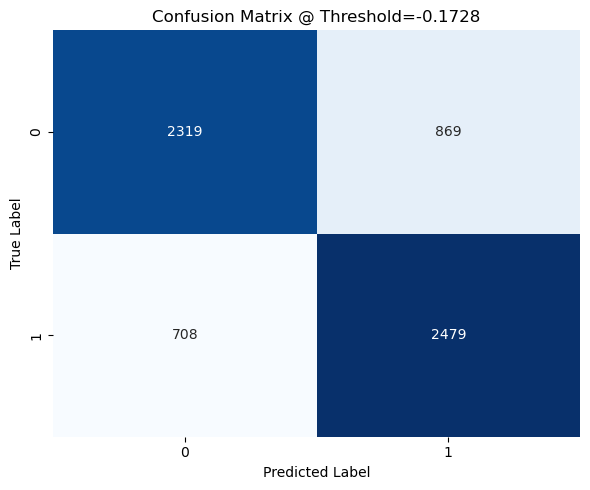

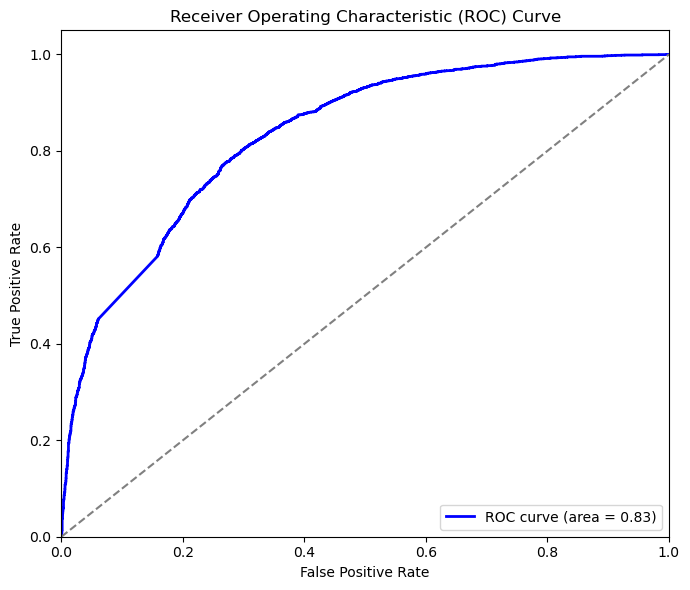

In [29]:
fpr, tpr, thresholds, roc_auc = evaluate_with_auroc(model, test_dataset, device)